In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
import sys
sys.executable

'/home/joz608/.conda/envs/jupyter_launcher/bin/python3.8'

In [3]:
import sys
import os
import copy
import pathlib
import time
import gc

from tqdm import tqdm, trange
# from tqdm import trange

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

import torch
import torchvision
import torchvision.transforms as transforms

# import cuml

# for creating validation set
import sklearn
from sklearn.model_selection import train_test_split

%matplotlib inline
%matplotlib inline
# %matplotlib inline
# %matplotlib qt

In [4]:
base_dir = '/n/data1/hms/neurobio/sabatini/josh'

In [5]:
import sys

sys.path.append(f'{base_dir}/github_repos')
# sys.path.append(f'/media/rich/Home_Linux_partition/github_repos')
dir_folders = f'{base_dir}/label_data'


%load_ext autoreload
%autoreload 2
from basic_neural_processing_modules import torch_helpers, math_functions, classification, h5_handling, plotting_helpers, indexing, misc #, decomposition
from GCaMP_ROI_classifier.new_stuff import util, models, training_simCLR, augmentation, training_classHead, training_supervised

## Import unlabeled training data

In [6]:
# data_unlabeled = h5_handling.simple_load(path=r'/media/rich/bigSSD/for_Josh/GCAMP_ROI_Classifier_data/masks_20211202_balanced.h5')
data_unlabeled = h5_handling.simple_load(path=f'{base_dir}/label_data/masks_20211202_balanced.h5')

masks_cat_raw = torch.as_tensor(np.concatenate((data_unlabeled['SYTmasks'], data_unlabeled['NPmasks'], data_unlabeled['RHmasks']), axis=0), dtype=torch.float32, device='cpu')

In [7]:
# data_labeled = h5_handling.simple_load(path=r'/media/rich/bigSSD/for_Josh/GCAMP_ROI_Classifier_data/masks_20211202_unbalanced.h5')

In [8]:
# masks_SYT = data_labeled['SYTmasks']
# labels_SYT = classification.squeeze_integers(data_labeled['SYTlabels'])

In [9]:
# nan_lst = np.concatenate(np.where(np.isnan(masks_SYT).sum(axis=-1).sum(axis=-1)))
# non_nan = [_ for _ in range(masks_SYT.shape[0]) if _ not in nan_lst]
# labels_SYT = labels_SYT[non_nan]
# masks_SYT = masks_SYT[non_nan]

In [10]:
# X_labeled_train_SYT, X_labeled_val_SYT, y_labeled_train_SYT, y_labeled_val_SYT = train_test_split(masks_SYT, labels_SYT, test_size = 0.2)

toss any NaNs

In [11]:
print(f'Number of masks: {masks_cat_raw.shape}')

ROIs_without_NaNs = torch.where(~torch.any(torch.any(torch.isnan(masks_cat_raw), dim=1), dim=1))[0]
masks_cat = masks_cat_raw[ROIs_without_NaNs]

print(f'Number of masks: {masks_cat.shape}')

Number of masks: torch.Size([711808, 36, 36])
Number of masks: torch.Size([711807, 36, 36])


## Import labeled training data

concatenated images shape: (9715, 32, 32)


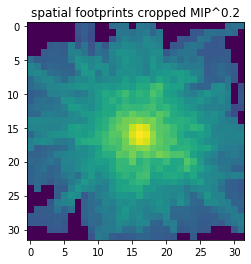

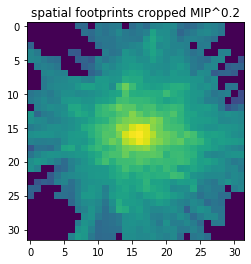

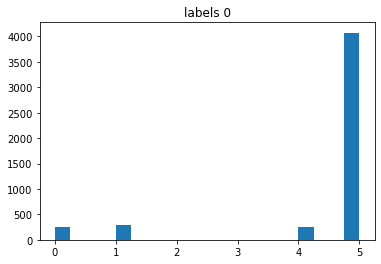

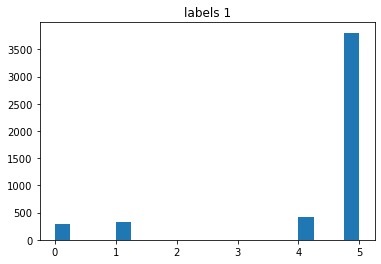

In [12]:
dir_folders = f'{base_dir}/label_data'
# dir_folders = r'/media/rich/bigSSD/for_Josh/GCAMP_ROI_Classifier_data/label_data'
# dir_folders = r'/users/Josh/Documents/Harvard/label_data'
folders = [r'mouse 6_28 _ day 20200903/',
             r'mouse6_28 _ day20200815/']
fileNames_statFiles = [r'stat.npy']*len(folders)
paths_statFiles = [pathlib.Path(dir_folders) / folders[ii] / fileNames_statFiles[ii] for ii in range(len(folders))]

sf_all = util.import_multiple_stat_files(   paths_statFiles=paths_statFiles,
                                            fileNames_statFiles=fileNames_statFiles,
                                            out_height_width=[32,32],
                                            max_footprint_width=241,
                                            plot_pref=True)
images_labeled_raw = np.concatenate(sf_all, axis=0)
images_labeled_raw = (images_labeled_raw / np.max(images_labeled_raw, axis=(1,2), keepdims=True)) * 1
print(f'concatenated images shape: {images_labeled_raw.shape}')

fileNames_labelFiles = ['labels_posthoc_filledIn_allCells.npy',
             'labels_posthoc_all.npy']
paths_labelFiles = [pathlib.Path(dir_folders) / folders[ii] / fileNames_labelFiles[ii] for ii in range(len(folders))]

labels_all = util.import_multiple_label_files(paths_labelFiles=paths_labelFiles,
                                       plot_pref=True)
labels_raw = np.concatenate(labels_all)

assert np.alltrue([sf_all[ii].shape[0] == labels_all[ii].shape[0] for ii in range(len(sf_all))]) , 'num images in stat files does not correspond to num labels'

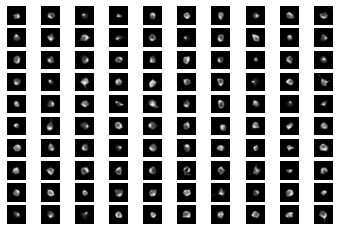

In [13]:
%matplotlib inline

plotting_helpers.plot_image_grid(images=images_labeled_raw,
                                labels=None,
                                grid_shape=(10,10), cmap=plt.get_cmap('gray'));

In [14]:
labels = classification.squeeze_integers(labels_raw)
images_labeled = images_labeled_raw[labels != 2]
labels = labels[labels != 2]
labels = classification.squeeze_integers(labels)

## Balance classes of inputs

In [15]:
duplicates = 1
balanced = True

images_dup = np.tile(images_labeled , (duplicates , 1 , 1))
labels_dup = np.tile(labels , (duplicates))

print(images_dup.shape)
print(labels_dup.shape)

if balanced:
    numToGetTo = np.sum(labels_dup==0)
    print(numToGetTo)
    for ii in np.array([1,2,3]):
  #     idxToDelete = np.cumsum(labels_dup==ii) <= (np.sum(labels_dup==ii) - numToGetTo)
        if ii==3:
            numToGetTo = np.sum(labels_dup==0)/1
        else:
            numToGetTo = np.sum(labels_dup==0)

        idxToDelete = (np.cumsum(labels_dup==ii) * (labels_dup==ii)) > numToGetTo
        images_dup = images_dup[idxToDelete==0,:,:]
        labels_dup = labels_dup[idxToDelete==0]





print(images_dup.shape)
print(labels_dup.shape)

numToGetTo = np.sum(labels_dup==0)
print(numToGetTo)

print(np.sum(labels_dup==0))
print(np.sum(labels_dup==1))
print(np.sum(labels_dup==4))
print(np.sum(labels_dup==5))
print(images_dup.shape)
print(labels_dup.shape)

(9714, 32, 32)
(9714,)
532
(2128, 32, 32)
(2128,)
532
532
532
0
0
(2128, 32, 32)
(2128,)


In [16]:
# create validation set

###### REMOVE WITH ENOUGH RAM
images = images_dup
labels = labels_dup

# X_labeled_train, X_labeled_val, y_labeled_train, y_labeled_val = train_test_split(images_dup, labels_dup, test_size = 0.3)
X_labeled_train, X_labeled_val, y_labeled_train, y_labeled_val = train_test_split(images_dup, labels_dup, test_size = 0.2)
# X_train, y_train = X_labeled_train, y_labeled_train

# X_labeled_val, X_test, y_labeled_val, y_test = train_test_split(X_labeled_val, y_labeled_val, test_size = 0.5)
X_val, X_test, y_val, y_test = train_test_split(X_labeled_val, y_labeled_val, test_size = 0.5)

(X_labeled_train.shape, y_labeled_train.shape), (X_labeled_val.shape, y_labeled_val.shape)

(((1702, 32, 32), (1702,)), ((426, 32, 32), (426,)))

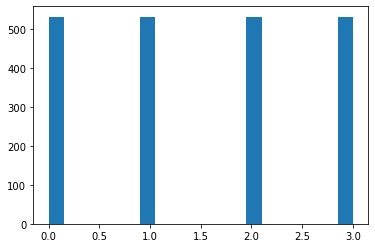

In [17]:
plt.figure()
plt.hist(labels_dup, 20);

In [18]:
images.shape

(2128, 32, 32)

# Train

In [19]:
# DEVICE = torch_helpers.set_device(use_GPU=True)
# DEVICE = torch_helpers.set_device(use_GPU=False)
DEVICE=0

### Define New model = model + pre-head + latent layer OR classification layer

In [20]:
class ModelTackOn(torch.nn.Module):
    def __init__(self, base_model, un_modified_model, pre_head_fc_sizes=[100], post_head_fc_sizes=[100], classifier_fc_sizes=None):
            super(ModelTackOn, self).__init__()
            self.base_model = base_model
            final_base_layer = list(un_modified_model.children())[-1]
            # final_base_layer = list(list(model.children())[-1].children())[-1]
            # print(final_base_layer)

            self.pre_head_fc_lst = []
            self.post_head_fc_lst = []
            self.classifier_fc_lst = []

            self.init_prehead(final_base_layer, pre_head_fc_sizes)
            self.init_posthead(pre_head_fc_sizes[-1], post_head_fc_sizes)
#             if classifier_fc_sizes is not None:
#                 self.init_classifier(pre_head_fc_sizes[-1], classifier_fc_sizes)
            
            # self.base_model = torch.nn.DataParallel(self.base_model)
            
            
    def init_prehead(self, prv_layer, pre_head_fc_sizes):
        for i, pre_head_fc in enumerate(pre_head_fc_sizes):
            if i == 0:
                in_features = prv_layer.in_features if hasattr(prv_layer,'in_features') else 512
            else:
                in_features = pre_head_fc_sizes[i - 1]
            fc_layer = torch.nn.Linear(in_features=in_features, out_features=pre_head_fc)
            
            self.base_model.add_module(f'PreHead_{i}', fc_layer)
            self.pre_head_fc_lst.append(fc_layer)

#             if i < len(pre_head_fc_sizes) - 1:
            non_linearity = torch.nn.ReLU()
            self.base_model.add_module(f'PreHead_{i}_NonLinearity', non_linearity)
            self.pre_head_fc_lst.append(non_linearity)

    def init_posthead(self, prv_size, post_head_fc_sizes):
        for i, post_head_fc in enumerate(post_head_fc_sizes):
            if i == 0:
                in_features = prv_size
            else:
                in_features = post_head_fc_sizes[i - 1]
            fc_layer = torch.nn.Linear(in_features=in_features, out_features=post_head_fc)
            
            self.base_model.add_module(f'PostHead_{i}', fc_layer)
            self.post_head_fc_lst.append(fc_layer)

            if i < len(post_head_fc_sizes) - 1:
                non_linearity = torch.nn.ReLU()
                self.base_model.add_module(f'PostHead_{i}_NonLinearity', non_linearity)
                self.pre_head_fc_lst.append(non_linearity)
    
    def init_classifier(self, prv_size, classifier_fc_sizes):
            for i, classifier_fc in enumerate(classifier_fc_sizes):
                if i == 0:
                    in_features = prv_size
                else:
                    in_features = classifier_fc_sizes[i - 1]
            fc_layer = torch.nn.Linear(in_features=in_features, out_features=classifier_fc)
            
            self.add_module(f'Classifier_{i}', fc_layer)
            self.classifier_fc_lst.append(fc_layer)

    def reinit_classifier(self):
        for i_layer, layer in enumerate(self.classifier_fc_lst):
            layer.reset_parameters()
    
    def forward(self, X):
        return self.forward_latent(X)

    def forward_classifier(self, X):
        interim = self.base_model(X)
        interim = self.get_head(interim)
        interim = self.classify(interim)
        return interim

    def forward_latent(self, X):
        interim = self.base_model(X)
        # interim = self.get_head(interim)
        # interim = self.get_latent(interim)
        return interim


    def get_head(self, base_out):
        # print('base_out', base_out.shape)
        head = base_out
        for pre_head_layer in self.pre_head_fc_lst:
          # print('pre_head_layer', pre_head_layer.in_features)
          head = pre_head_layer(head)
          # print('head', head.shape)
        return head

    def get_latent(self, head):
        latent = head
        for post_head_layer in self.post_head_fc_lst:
            latent = post_head_layer(latent)
        return latent

    def classify(self, head):
        logit = head
        for classifier_layer in self.classifier_fc_lst:
            logit = classifier_layer(logit)
        return logit

    def set_pre_head_grad(self, requires_grad=True):
        for layer in self.pre_head_fc_lst:
            for param in layer.parameters():
                param.requires_grad = requires_grad
                
    def set_post_head_grad(self, requires_grad=True):
        for layer in self.post_head_fc_lst:
            for param in layer.parameters():
                param.requires_grad = requires_grad

    def set_classifier_grad(self, requires_grad=True):
        for layer in self.classifier_fc_lst:
            for param in layer.parameters():
                param.requires_grad = requires_grad

    def prep_contrast(self):
        self.set_pre_head_grad(requires_grad=True)
        self.set_post_head_grad(requires_grad=True)
        self.set_classifier_grad(requires_grad=False)

    def prep_classifier(self):
        self.set_pre_head_grad(requires_grad=False)
        self.set_post_head_grad(requires_grad=False)
        self.set_classifier_grad(requires_grad=True)


In [21]:
# import torchvision.models

# # base_model = torchvision.models.resnet101(pretrained=True)
# base_model = torchvision.models.resnet18(pretrained=True)

# for param in base_model.parameters():
#     param.requires_grad = False

# retrain = list(base_model.children())[-1:]
# for layer in retrain:
#     params = layer.parameters()
#     for param in params:
#         param.requires_grad = True

In [22]:
import torchvision.models

# base_model_frozen = torchvision.models.resnet101(pretrained=True)
base_model_frozen = torchvision.models.resnet18(pretrained=True)
# base_model_frozen = torchvision.models.wide_resnet50_2(pretrained=True)
# base_model_frozen = torchvision.models.resnet50(pretrained=True)
for param in base_model_frozen.parameters():
    param.requires_grad = False

start with a pretrained resnet model, and chop off the final layer. This will be used as the base on which we add the pre-head layers (for expressivity), latent layers (for simCLR), or classification layers (for post-hoc logistic regression)

In [23]:
model_chopped = torch.nn.Sequential(*(list(base_model_frozen.children())[:-1] + [torch.nn.Flatten()]))

### Make combined model
'model' has two forward methods. One for generating latents (for simCLR) and one for classifying labels

In [24]:
model = ModelTackOn(model_chopped, base_model_frozen, pre_head_fc_sizes=[1024, 512], post_head_fc_sizes=[64], classifier_fc_sizes=[len(np.unique(y_labeled_train))])
# model = ModelTackOn(model_chopped.to(DEVICE), base_model_frozen, pre_head_fc_sizes=[len(np.unique(y_train))], post_head_fc_sizes=[])
# model = ModelTackOn(model_chopped.to(DEVICE), base_model_frozen, pre_head_fc_sizes=[len(np.unique(y_train))], post_head_fc_sizes=[])

# model = torch.nn.Sequential([model_chopped.to(DEVICE), torch.nn.Linear], pre_head_fc_sizes=[len(np.unique(y_train))], post_head_fc_sizes=[])


# model = ModelTackOn(base_model_frozen, pre_head_fc_sizes=[len(np.unique(y_train))], post_head_fc_sizes=[])
# model = ModelTackOn(base_model, pre_head_fc_sizes=[len(np.unique(y_train))], post_head_fc_sizes=[])
model.train();

In [25]:
# model

In [26]:
# unfreeze particular blocks in ResNet model

for name, param in list(model.named_parameters()):
    if name[:10] == 'base_model':
        if name[11].isnumeric():
            if int(name[11]) < 6:
                param.requires_grad = False
            else:
                param.requires_grad = True

for name, param in list(model.named_parameters()):
    if param.requires_grad:
        print(name, name[11], name[11].isnumeric())

base_model.6.0.conv1.weight 6 True
base_model.6.0.bn1.weight 6 True
base_model.6.0.bn1.bias 6 True
base_model.6.0.conv2.weight 6 True
base_model.6.0.bn2.weight 6 True
base_model.6.0.bn2.bias 6 True
base_model.6.0.downsample.0.weight 6 True
base_model.6.0.downsample.1.weight 6 True
base_model.6.0.downsample.1.bias 6 True
base_model.6.1.conv1.weight 6 True
base_model.6.1.bn1.weight 6 True
base_model.6.1.bn1.bias 6 True
base_model.6.1.conv2.weight 6 True
base_model.6.1.bn2.weight 6 True
base_model.6.1.bn2.bias 6 True
base_model.7.0.conv1.weight 7 True
base_model.7.0.bn1.weight 7 True
base_model.7.0.bn1.bias 7 True
base_model.7.0.conv2.weight 7 True
base_model.7.0.bn2.weight 7 True
base_model.7.0.bn2.bias 7 True
base_model.7.0.downsample.0.weight 7 True
base_model.7.0.downsample.1.weight 7 True
base_model.7.0.downsample.1.bias 7 True
base_model.7.1.conv1.weight 7 True
base_model.7.1.bn1.weight 7 True
base_model.7.1.bn1.bias 7 True
base_model.7.1.conv2.weight 7 True
base_model.7.1.bn2.weigh

## Define augmentation pipeline

In [27]:
import torchvision.transforms    

transforms = torch.nn.Sequential(
    
#     torchvision.transforms.RandomAdjustSharpness(torch.rand(1)*5, p=0.5),
#         torchvision.transforms.RandomPerspective(distortion_scale=0.7, 
#                                              p=0.5, 
#                                              interpolation=torchvision.transforms.InterpolationMode.BILINEAR, 
#                                              fill=0),
#     torchvision.transforms.GaussianBlur(kernel_size=5,
#                                         sigma=(0.0001, 0.1)),
        

    torchvision.transforms.RandomHorizontalFlip(p=0.5),
        
    torchvision.transforms.RandomAffine(
                                        degrees=(-180,180),
                                        translate=(0.2, 0.2),
                                        scale=(0.4, 1.3), 
                                        shear=(-25, 25, -25, 25), 
                                        interpolation=torchvision.transforms.InterpolationMode.BILINEAR, 
                                        fill=0, 
                                        fillcolor=None, 
                                        resample=None),
    augmentation.AddPoissonNoise(   scaler_bounds=(10**(4.0), 10**(6.)),
                                    prob=1,
                                    base=1000,
                                    scaling='log'),
    augmentation.AddGaussianNoise(  mean=0, 
                                    std=0.0002,
                                    prob=1),
    augmentation.ScaleDynamicRange(scaler_bounds=(0,1)),
    torchvision.transforms.Resize(size=(224,224),
                                  interpolation=torchvision.transforms.InterpolationMode.BILINEAR), 
    augmentation.AddPoissonNoise(   scaler_bounds=(10**(1.5), 10**(4.0)),
                                    prob=1,
                                    base=1000,
                                    scaling='log'),
    augmentation.AddGaussianNoise(  mean=0, 
                                    std=0.1,
                                    prob=1),
    augmentation.TileChannels(dim=0, n_channels=3),
#     augmentation.Normalize(  means=[0.485, 0.456, 0.406],
#                              stds=[0.229, 0.224, 0.225]),
#     torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                                      std=[0.229, 0.224, 0.225],
#                                      inplace=False),
#     torchvision.transforms.RandomHorizontalFlip(p=0.5),

#     torchvision.transforms.RandomAffine(
#                                         degrees=(-180,180),
#                                         translate=(0.0, 0.0),
#                                         interpolation=torchvision.transforms.InterpolationMode.BILINEAR, 
#                                         fill=0, 
#                                         # fillcolor=None, 
#                                         resample=None),
)
scripted_transforms = torch.jit.script(transforms)
# scripted_transforms = transforms

In [28]:
dataset_train = util.dataset_simCLR(
                                    torch.as_tensor(masks_cat, device='cpu', dtype=torch.float32), 
                                    torch.as_tensor(torch.zeros(masks_cat.shape[0]), device='cpu', dtype=torch.float32),

                                    n_transforms=2,
                                    class_weights=np.array([1]),
                                    # class_weights=np.array([1]*4)[np.random.randint(0,4, X_train.shape[0])],
                                    transform=scripted_transforms,
                                    DEVICE='cpu',
                                    # DEVICE=0,
                                    dtype_X=torch.float32,
                                    dtype_y=torch.int64,
                                    
                                    temp_uncertainty=16
                                    )
dataloader_train = torch.utils.data.DataLoader( dataset_train,
#                                                 batch_size=int(pct_batch_size*X_train.shape[0]),
                                                batch_size=1024,
                                                shuffle=True,
                                                drop_last=True,
                                                pin_memory=True,
                                                num_workers=20,
                                                persistent_workers=True,
                                                # prefetch_factor=2
                                                )


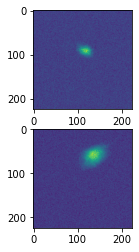

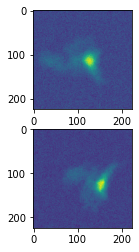

In [29]:
idx_rand = np.random.randint(0,masks_cat.shape[0], 2)
for ii in idx_rand:
    fig, axs = plt.subplots(2)
    axs[0].imshow(dataset_train[ii][0][0][0].cpu())
    axs[1].imshow(dataset_train[ii][0][1][0].cpu())

In [30]:
# torch_helpers.delete_all_cuda_tensors(globals())

import gc

torch.cuda.empty_cache()
gc.collect()
torch.cuda.empty_cache()
gc.collect()
torch.cuda.empty_cache()
gc.collect()
torch.cuda.empty_cache()
gc.collect()

0

## Training

In [31]:
# model.to(DEVICE)
model.prep_contrast()

In [32]:
torch_helpers.show_cuda_devices()

3 device(s) found.
0 Quadro RTX 8000
1 Quadro RTX 8000
2 Quadro RTX 8000


In [33]:
model_parallel = torch.nn.DataParallel(model, device_ids=[0, 1, 2])
# model_parallel = torch.nn.DataParallel(model, ) 

In [34]:
torch_helpers.show_all_tensors(globals())

var: masks_cat_raw,   device:cpu,   shape: torch.Size([711808, 36, 36]),   size: 3.690012672 GB,   requires_grad: False
var: ROIs_without_NaNs,   device:cpu,   shape: torch.Size([711807]),   size: 0.005694456 GB,   requires_grad: False
var: masks_cat,   device:cpu,   shape: torch.Size([711807, 36, 36]),   size: 3.690007488 GB,   requires_grad: False


In [35]:
from torch.nn import CrossEntropyLoss
from torch.optim import Adam

import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC


# model = models.LeNet1(dropout_prob=0.3, momentum_val=0, n_output_features=64)


criterion = [CrossEntropyLoss()]
# criterion = CrossEntropyLoss(reduction='none')

# optimizer = Adam(model.parameters(), lr=1e-2, weight_decay=0.0)
# optimizer = Adam(model.parameters(), lr=2e-2)
optimizer = Adam(model.parameters(), lr=10**(-3.5))
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer,
                                                   gamma=1-0.0000,
#                                                    gamma=1,
                                                  )

# criterion = [_.to(DEVICE) for _ in criterion]
# criterion = [_ for _ in criterion]
losses_train, losses_val, val_accs, acc = [], [np.nan], [], []

In [36]:
model_parallel.to(0);

In [37]:
# chopped_parallel = torch.nn.DataParallel(model_chopped, device_ids=[0,1,2])

In [38]:
test_data = torch.rand(100,3,224,224, dtype=torch.float32, device=0)
# model.forward(test_data)
model_parallel.forward(test_data)
# chopped_parallel.forward(test_data)

tensor([[ 0.2404,  0.0128,  0.2456,  ...,  0.0054,  0.1058, -0.0937],
        [ 0.2258,  0.0810,  0.1474,  ...,  0.0128, -0.0015,  0.0386],
        [ 0.1850, -0.1030,  0.2427,  ..., -0.0209,  0.1576,  0.0269],
        ...,
        [ 0.1244, -0.0533,  0.2121,  ...,  0.0425,  0.1055, -0.0326],
        [ 0.0988, -0.0051,  0.1536,  ...,  0.1117,  0.0398,  0.0576],
        [ 0.1317,  0.0796,  0.1021,  ...,  0.0725,  0.0170,  0.0077]],
       device='cuda:0', grad_fn=<GatherBackward>)

In [39]:
# for param in model_parallel.parameters():
#     print(param.device)

In [ ]:
l2_alpha = 0.000

n_epochs=300000
for epoch in tqdm(range(n_epochs)):
    print(f'epoch: {epoch}')
    loss_rolling_train = training_simCLR.epoch_step(dataloader_train, 
                                    # model, 
                                    model_parallel, 
                                    optimizer, 
                                    criterion,
                                    scheduler=scheduler,
                                    temperature=0.2,
                                    # l2_alpha,
                                    mode='semi-supervised',
                                    loss_rolling_train=losses_train, 
                                    loss_rolling_val=losses_val,
                                    device=0, 
                                    verbose=2,
                                    verbose_update_period=1,
                                   
#                                     do_validation=False,
#                                     X_val=x_feed_through_val,
#                                     y_val=torch.as_tensor(y_val, device=DEVICE)
                                   )

  0%|          | 0/300000 [00:00<?, ?it/s]

epoch: 0
Iter: 0/695, loss_train: 7.6106, loss_val: nan, pos_over_neg: 1.0100092887878418 lr: 0.00031623
Iter: 1/695, loss_train: 7.4306, loss_val: nan, pos_over_neg: 1.0811201333999634 lr: 0.00031623
Iter: 2/695, loss_train: 7.3048, loss_val: nan, pos_over_neg: 1.6084449291229248 lr: 0.00031623
Iter: 3/695, loss_train: 7.2868, loss_val: nan, pos_over_neg: 1.3654723167419434 lr: 0.00031623
Iter: 4/695, loss_train: 7.058, loss_val: nan, pos_over_neg: 1.2637993097305298 lr: 0.00031623
Iter: 5/695, loss_train: 6.9146, loss_val: nan, pos_over_neg: 1.451255202293396 lr: 0.00031623
Iter: 6/695, loss_train: 6.7889, loss_val: nan, pos_over_neg: 1.9823416471481323 lr: 0.00031623
Iter: 7/695, loss_train: 6.6413, loss_val: nan, pos_over_neg: 2.8610496520996094 lr: 0.00031623
Iter: 8/695, loss_train: 6.6275, loss_val: nan, pos_over_neg: 3.529315233230591 lr: 0.00031623
Iter: 9/695, loss_train: 6.5229, loss_val: nan, pos_over_neg: 3.92543625831604 lr: 0.00031623
Iter: 10/695, loss_train: 6.4852, lo

  0%|          | 1/300000 [15:28<77389:09:33, 928.67s/it]

Iter: 694/695, loss_train: 3.9996, loss_val: nan, pos_over_neg: 221.7789764404297 lr: 0.00031623
epoch: 1
Iter: 0/695, loss_train: 4.0963, loss_val: nan, pos_over_neg: 112.41771697998047 lr: 0.00031623
Iter: 1/695, loss_train: 4.0751, loss_val: nan, pos_over_neg: 138.1513671875 lr: 0.00031623
Iter: 2/695, loss_train: 4.0033, loss_val: nan, pos_over_neg: 195.693603515625 lr: 0.00031623
Iter: 3/695, loss_train: 4.0682, loss_val: nan, pos_over_neg: 197.64073181152344 lr: 0.00031623
Iter: 4/695, loss_train: 4.051, loss_val: nan, pos_over_neg: 216.97677612304688 lr: 0.00031623
Iter: 5/695, loss_train: 4.079, loss_val: nan, pos_over_neg: 178.913330078125 lr: 0.00031623
Iter: 6/695, loss_train: 4.0528, loss_val: nan, pos_over_neg: 261.31243896484375 lr: 0.00031623
Iter: 7/695, loss_train: 4.0514, loss_val: nan, pos_over_neg: 199.71282958984375 lr: 0.00031623
Iter: 8/695, loss_train: 4.1074, loss_val: nan, pos_over_neg: 208.39236450195312 lr: 0.00031623
Iter: 9/695, loss_train: 3.9882, loss_va

  0%|          | 2/300000 [30:34<76280:22:43, 915.37s/it]

Iter: 694/695, loss_train: 3.8625, loss_val: nan, pos_over_neg: 303.62420654296875 lr: 0.00031623
epoch: 2
Iter: 0/695, loss_train: 3.8476, loss_val: nan, pos_over_neg: 245.13450622558594 lr: 0.00031623
Iter: 1/695, loss_train: 3.9036, loss_val: nan, pos_over_neg: 286.5736999511719 lr: 0.00031623
Iter: 2/695, loss_train: 3.891, loss_val: nan, pos_over_neg: 213.7187957763672 lr: 0.00031623
Iter: 3/695, loss_train: 3.8562, loss_val: nan, pos_over_neg: 218.32717895507812 lr: 0.00031623
Iter: 4/695, loss_train: 3.8885, loss_val: nan, pos_over_neg: 150.40284729003906 lr: 0.00031623
Iter: 5/695, loss_train: 3.8679, loss_val: nan, pos_over_neg: 165.22605895996094 lr: 0.00031623
Iter: 6/695, loss_train: 3.8922, loss_val: nan, pos_over_neg: 216.0522918701172 lr: 0.00031623
Iter: 7/695, loss_train: 3.8552, loss_val: nan, pos_over_neg: 275.8893127441406 lr: 0.00031623
Iter: 8/695, loss_train: 3.8881, loss_val: nan, pos_over_neg: 310.1696472167969 lr: 0.00031623
Iter: 9/695, loss_train: 3.8678, lo

  0%|          | 3/300000 [45:33<75647:01:19, 907.77s/it]

Iter: 694/695, loss_train: 3.8427, loss_val: nan, pos_over_neg: 289.8622131347656 lr: 0.00031623
epoch: 3
Iter: 0/695, loss_train: 3.794, loss_val: nan, pos_over_neg: 295.88214111328125 lr: 0.00031623
Iter: 1/695, loss_train: 3.7838, loss_val: nan, pos_over_neg: 302.9064025878906 lr: 0.00031623
Iter: 2/695, loss_train: 3.8254, loss_val: nan, pos_over_neg: 213.50436401367188 lr: 0.00031623
Iter: 3/695, loss_train: 3.819, loss_val: nan, pos_over_neg: 196.8424835205078 lr: 0.00031623
Iter: 4/695, loss_train: 3.8313, loss_val: nan, pos_over_neg: 268.9628601074219 lr: 0.00031623
Iter: 5/695, loss_train: 3.8448, loss_val: nan, pos_over_neg: 272.85076904296875 lr: 0.00031623
Iter: 6/695, loss_train: 3.8047, loss_val: nan, pos_over_neg: 288.224365234375 lr: 0.00031623
Iter: 7/695, loss_train: 3.8382, loss_val: nan, pos_over_neg: 229.23497009277344 lr: 0.00031623
Iter: 8/695, loss_train: 3.7792, loss_val: nan, pos_over_neg: 311.0002136230469 lr: 0.00031623
Iter: 9/695, loss_train: 3.824, loss_v

  0%|          | 4/300000 [1:00:37<75514:52:31, 906.19s/it]

Iter: 694/695, loss_train: 3.8115, loss_val: nan, pos_over_neg: 313.9820861816406 lr: 0.00031623
epoch: 4
Iter: 0/695, loss_train: 3.7789, loss_val: nan, pos_over_neg: 176.9964599609375 lr: 0.00031623
Iter: 1/695, loss_train: 3.7588, loss_val: nan, pos_over_neg: 318.3659973144531 lr: 0.00031623
Iter: 2/695, loss_train: 3.7385, loss_val: nan, pos_over_neg: 345.0010681152344 lr: 0.00031623
Iter: 3/695, loss_train: 3.7714, loss_val: nan, pos_over_neg: 450.0994567871094 lr: 0.00031623
Iter: 4/695, loss_train: 3.7201, loss_val: nan, pos_over_neg: 369.3482666015625 lr: 0.00031623
Iter: 5/695, loss_train: 3.7531, loss_val: nan, pos_over_neg: 257.606689453125 lr: 0.00031623
Iter: 6/695, loss_train: 3.7787, loss_val: nan, pos_over_neg: 218.99575805664062 lr: 0.00031623
Iter: 7/695, loss_train: 3.7549, loss_val: nan, pos_over_neg: 229.75196838378906 lr: 0.00031623
Iter: 8/695, loss_train: 3.7695, loss_val: nan, pos_over_neg: 246.35531616210938 lr: 0.00031623
Iter: 9/695, loss_train: 3.7624, loss

  0%|          | 5/300000 [1:15:41<75455:24:29, 905.48s/it]

Iter: 694/695, loss_train: 3.7135, loss_val: nan, pos_over_neg: 305.20379638671875 lr: 0.00031623
epoch: 5
Iter: 0/695, loss_train: 3.7016, loss_val: nan, pos_over_neg: 512.1918334960938 lr: 0.00031623
Iter: 1/695, loss_train: 3.7261, loss_val: nan, pos_over_neg: 370.0746765136719 lr: 0.00031623
Iter: 2/695, loss_train: 3.685, loss_val: nan, pos_over_neg: 473.0284118652344 lr: 0.00031623
Iter: 3/695, loss_train: 3.6914, loss_val: nan, pos_over_neg: 587.31982421875 lr: 0.00031623
Iter: 4/695, loss_train: 3.6888, loss_val: nan, pos_over_neg: 450.1361999511719 lr: 0.00031623
Iter: 5/695, loss_train: 3.7032, loss_val: nan, pos_over_neg: 518.4842529296875 lr: 0.00031623
Iter: 6/695, loss_train: 3.664, loss_val: nan, pos_over_neg: 558.9545288085938 lr: 0.00031623
Iter: 7/695, loss_train: 3.725, loss_val: nan, pos_over_neg: 270.1484375 lr: 0.00031623
Iter: 8/695, loss_train: 3.6645, loss_val: nan, pos_over_neg: 277.1529846191406 lr: 0.00031623
Iter: 9/695, loss_train: 3.6915, loss_val: nan, p

  0%|          | 6/300000 [1:30:46<75443:16:37, 905.34s/it]

Iter: 694/695, loss_train: 3.6972, loss_val: nan, pos_over_neg: 237.25430297851562 lr: 0.00031623
epoch: 6
Iter: 0/695, loss_train: 3.7103, loss_val: nan, pos_over_neg: 314.2431945800781 lr: 0.00031623
Iter: 1/695, loss_train: 3.7032, loss_val: nan, pos_over_neg: 320.0061340332031 lr: 0.00031623
Iter: 2/695, loss_train: 3.7349, loss_val: nan, pos_over_neg: 266.8605651855469 lr: 0.00031623
Iter: 3/695, loss_train: 3.652, loss_val: nan, pos_over_neg: 622.6722412109375 lr: 0.00031623
Iter: 4/695, loss_train: 3.7196, loss_val: nan, pos_over_neg: 308.4683837890625 lr: 0.00031623
Iter: 5/695, loss_train: 3.7342, loss_val: nan, pos_over_neg: 274.7271423339844 lr: 0.00031623
Iter: 6/695, loss_train: 3.67, loss_val: nan, pos_over_neg: 439.6731872558594 lr: 0.00031623
Iter: 7/695, loss_train: 3.7694, loss_val: nan, pos_over_neg: 248.04119873046875 lr: 0.00031623
Iter: 8/695, loss_train: 3.6781, loss_val: nan, pos_over_neg: 332.2933349609375 lr: 0.00031623
Iter: 9/695, loss_train: 3.6949, loss_va

  0%|          | 7/300000 [1:45:46<75292:31:01, 903.53s/it]

Iter: 694/695, loss_train: 3.6908, loss_val: nan, pos_over_neg: 372.93060302734375 lr: 0.00031623
epoch: 7
Iter: 0/695, loss_train: 3.7344, loss_val: nan, pos_over_neg: 241.61790466308594 lr: 0.00031623
Iter: 1/695, loss_train: 3.6693, loss_val: nan, pos_over_neg: 339.0138244628906 lr: 0.00031623
Iter: 2/695, loss_train: 3.6417, loss_val: nan, pos_over_neg: 416.8945007324219 lr: 0.00031623
Iter: 3/695, loss_train: 3.6596, loss_val: nan, pos_over_neg: 487.5563659667969 lr: 0.00031623
Iter: 4/695, loss_train: 3.6524, loss_val: nan, pos_over_neg: 382.6783447265625 lr: 0.00031623
Iter: 5/695, loss_train: 3.6737, loss_val: nan, pos_over_neg: 411.1014709472656 lr: 0.00031623
Iter: 6/695, loss_train: 3.6726, loss_val: nan, pos_over_neg: 406.54931640625 lr: 0.00031623
Iter: 7/695, loss_train: 3.6699, loss_val: nan, pos_over_neg: 401.423828125 lr: 0.00031623
Iter: 8/695, loss_train: 3.6575, loss_val: nan, pos_over_neg: 444.0557861328125 lr: 0.00031623
Iter: 9/695, loss_train: 3.6736, loss_val: 

  0%|          | 8/300000 [2:00:43<75124:07:56, 901.51s/it]

Iter: 694/695, loss_train: 3.6347, loss_val: nan, pos_over_neg: 440.7281494140625 lr: 0.00031623
epoch: 8
Iter: 0/695, loss_train: 3.672, loss_val: nan, pos_over_neg: 385.0672302246094 lr: 0.00031623
Iter: 1/695, loss_train: 3.656, loss_val: nan, pos_over_neg: 315.0892028808594 lr: 0.00031623
Iter: 2/695, loss_train: 3.6434, loss_val: nan, pos_over_neg: 409.05841064453125 lr: 0.00031623
Iter: 3/695, loss_train: 3.6573, loss_val: nan, pos_over_neg: 341.3085632324219 lr: 0.00031623
Iter: 4/695, loss_train: 3.661, loss_val: nan, pos_over_neg: 323.9191589355469 lr: 0.00031623
Iter: 5/695, loss_train: 3.6865, loss_val: nan, pos_over_neg: 266.92822265625 lr: 0.00031623
Iter: 6/695, loss_train: 3.6724, loss_val: nan, pos_over_neg: 280.4006652832031 lr: 0.00031623
Iter: 7/695, loss_train: 3.6953, loss_val: nan, pos_over_neg: 355.54571533203125 lr: 0.00031623
Iter: 8/695, loss_train: 3.6987, loss_val: nan, pos_over_neg: 279.92413330078125 lr: 0.00031623
Iter: 9/695, loss_train: 3.633, loss_val:

  0%|          | 9/300000 [2:15:51<75302:21:01, 903.66s/it]

Iter: 694/695, loss_train: 3.6346, loss_val: nan, pos_over_neg: 307.8758544921875 lr: 0.00031623
epoch: 9
Iter: 0/695, loss_train: 3.667, loss_val: nan, pos_over_neg: 384.30389404296875 lr: 0.00031623
Iter: 1/695, loss_train: 3.6758, loss_val: nan, pos_over_neg: 452.3017578125 lr: 0.00031623
Iter: 2/695, loss_train: 3.685, loss_val: nan, pos_over_neg: 289.26068115234375 lr: 0.00031623
Iter: 3/695, loss_train: 3.5972, loss_val: nan, pos_over_neg: 776.3763427734375 lr: 0.00031623
Iter: 4/695, loss_train: 3.6487, loss_val: nan, pos_over_neg: 355.4818115234375 lr: 0.00031623
Iter: 5/695, loss_train: 3.6081, loss_val: nan, pos_over_neg: 387.5028991699219 lr: 0.00031623
Iter: 6/695, loss_train: 3.6989, loss_val: nan, pos_over_neg: 264.13238525390625 lr: 0.00031623
Iter: 7/695, loss_train: 3.6236, loss_val: nan, pos_over_neg: 315.4355163574219 lr: 0.00031623
Iter: 8/695, loss_train: 3.649, loss_val: nan, pos_over_neg: 379.8302917480469 lr: 0.00031623
Iter: 9/695, loss_train: 3.6881, loss_val:

  0%|          | 10/300000 [2:31:00<75422:19:28, 905.10s/it]

Iter: 694/695, loss_train: 3.6352, loss_val: nan, pos_over_neg: 379.4442443847656 lr: 0.00031623
epoch: 10
Iter: 0/695, loss_train: 3.6161, loss_val: nan, pos_over_neg: 394.3394775390625 lr: 0.00031623
Iter: 1/695, loss_train: 3.6422, loss_val: nan, pos_over_neg: 544.0185546875 lr: 0.00031623
Iter: 2/695, loss_train: 3.6526, loss_val: nan, pos_over_neg: 398.9220275878906 lr: 0.00031623
Iter: 3/695, loss_train: 3.5952, loss_val: nan, pos_over_neg: 602.7649536132812 lr: 0.00031623
Iter: 4/695, loss_train: 3.6347, loss_val: nan, pos_over_neg: 438.0828857421875 lr: 0.00031623
Iter: 5/695, loss_train: 3.6007, loss_val: nan, pos_over_neg: 579.3838500976562 lr: 0.00031623
Iter: 6/695, loss_train: 3.6058, loss_val: nan, pos_over_neg: 405.13897705078125 lr: 0.00031623
Iter: 7/695, loss_train: 3.615, loss_val: nan, pos_over_neg: 550.7417602539062 lr: 0.00031623
Iter: 8/695, loss_train: 3.6351, loss_val: nan, pos_over_neg: 371.0616760253906 lr: 0.00031623
Iter: 9/695, loss_train: 3.6804, loss_val

  0%|          | 11/300000 [2:46:12<75598:39:15, 907.22s/it]

Iter: 694/695, loss_train: 3.641, loss_val: nan, pos_over_neg: 464.3194274902344 lr: 0.00031623
epoch: 11
Iter: 0/695, loss_train: 3.653, loss_val: nan, pos_over_neg: 315.9017639160156 lr: 0.00031623
Iter: 1/695, loss_train: 3.6194, loss_val: nan, pos_over_neg: 615.8638916015625 lr: 0.00031623
Iter: 2/695, loss_train: 3.6333, loss_val: nan, pos_over_neg: 432.37353515625 lr: 0.00031623
Iter: 3/695, loss_train: 3.6089, loss_val: nan, pos_over_neg: 394.6722106933594 lr: 0.00031623
Iter: 4/695, loss_train: 3.6058, loss_val: nan, pos_over_neg: 366.3486022949219 lr: 0.00031623
Iter: 5/695, loss_train: 3.5923, loss_val: nan, pos_over_neg: 450.6864929199219 lr: 0.00031623
Iter: 6/695, loss_train: 3.6396, loss_val: nan, pos_over_neg: 406.7554626464844 lr: 0.00031623
Iter: 7/695, loss_train: 3.6431, loss_val: nan, pos_over_neg: 491.5956115722656 lr: 0.00031623
Iter: 8/695, loss_train: 3.6119, loss_val: nan, pos_over_neg: 413.7459716796875 lr: 0.00031623
Iter: 9/695, loss_train: 3.6287, loss_val:

  0%|          | 12/300000 [3:01:16<75531:13:42, 906.41s/it]

Iter: 694/695, loss_train: 3.5959, loss_val: nan, pos_over_neg: 991.2781982421875 lr: 0.00031623
epoch: 12
Iter: 0/695, loss_train: 3.6201, loss_val: nan, pos_over_neg: 460.0372314453125 lr: 0.00031623
Iter: 1/695, loss_train: 3.5998, loss_val: nan, pos_over_neg: 564.41455078125 lr: 0.00031623
Iter: 2/695, loss_train: 3.6394, loss_val: nan, pos_over_neg: 361.38916015625 lr: 0.00031623
Iter: 3/695, loss_train: 3.6256, loss_val: nan, pos_over_neg: 433.179931640625 lr: 0.00031623
Iter: 4/695, loss_train: 3.6268, loss_val: nan, pos_over_neg: 580.346923828125 lr: 0.00031623
Iter: 5/695, loss_train: 3.635, loss_val: nan, pos_over_neg: 322.5214538574219 lr: 0.00031623
Iter: 6/695, loss_train: 3.6028, loss_val: nan, pos_over_neg: 457.7332763671875 lr: 0.00031623
Iter: 7/695, loss_train: 3.6239, loss_val: nan, pos_over_neg: 376.9748229980469 lr: 0.00031623
Iter: 8/695, loss_train: 3.59, loss_val: nan, pos_over_neg: 360.3763732910156 lr: 0.00031623
Iter: 9/695, loss_train: 3.565, loss_val: nan, 

  0%|          | 13/300000 [3:16:22<75501:45:04, 906.06s/it]

Iter: 694/695, loss_train: 3.6392, loss_val: nan, pos_over_neg: 364.817626953125 lr: 0.00031623
epoch: 13
Iter: 0/695, loss_train: 3.5883, loss_val: nan, pos_over_neg: 568.4603881835938 lr: 0.00031623
Iter: 1/695, loss_train: 3.6086, loss_val: nan, pos_over_neg: 277.5488586425781 lr: 0.00031623
Iter: 2/695, loss_train: 3.6259, loss_val: nan, pos_over_neg: 352.3114929199219 lr: 0.00031623
Iter: 3/695, loss_train: 3.622, loss_val: nan, pos_over_neg: 394.5813903808594 lr: 0.00031623
Iter: 4/695, loss_train: 3.6142, loss_val: nan, pos_over_neg: 559.482666015625 lr: 0.00031623
Iter: 5/695, loss_train: 3.6209, loss_val: nan, pos_over_neg: 382.8017272949219 lr: 0.00031623
Iter: 6/695, loss_train: 3.5693, loss_val: nan, pos_over_neg: 662.4328002929688 lr: 0.00031623
Iter: 7/695, loss_train: 3.6117, loss_val: nan, pos_over_neg: 387.96905517578125 lr: 0.00031623
Iter: 8/695, loss_train: 3.5906, loss_val: nan, pos_over_neg: 522.381103515625 lr: 0.00031623
Iter: 9/695, loss_train: 3.6352, loss_val

  0%|          | 14/300000 [3:31:27<75481:51:14, 905.82s/it]

Iter: 694/695, loss_train: 3.5631, loss_val: nan, pos_over_neg: 722.7366943359375 lr: 0.00031623
epoch: 14
Iter: 0/695, loss_train: 3.55, loss_val: nan, pos_over_neg: 706.462646484375 lr: 0.00031623
Iter: 1/695, loss_train: 3.6174, loss_val: nan, pos_over_neg: 397.46685791015625 lr: 0.00031623
Iter: 2/695, loss_train: 3.58, loss_val: nan, pos_over_neg: 349.9332275390625 lr: 0.00031623
Iter: 3/695, loss_train: 3.5711, loss_val: nan, pos_over_neg: 513.1766357421875 lr: 0.00031623
Iter: 4/695, loss_train: 3.6017, loss_val: nan, pos_over_neg: 372.22979736328125 lr: 0.00031623
Iter: 5/695, loss_train: 3.6097, loss_val: nan, pos_over_neg: 382.0314025878906 lr: 0.00031623
Iter: 6/695, loss_train: 3.6063, loss_val: nan, pos_over_neg: 298.2902526855469 lr: 0.00031623
Iter: 7/695, loss_train: 3.584, loss_val: nan, pos_over_neg: 383.3020324707031 lr: 0.00031623
Iter: 8/695, loss_train: 3.6402, loss_val: nan, pos_over_neg: 256.89453125 lr: 0.00031623
Iter: 9/695, loss_train: 3.5796, loss_val: nan,

  0%|          | 15/300000 [3:46:27<75344:07:49, 904.17s/it]

Iter: 694/695, loss_train: 3.5945, loss_val: nan, pos_over_neg: 390.33453369140625 lr: 0.00031623
epoch: 15
Iter: 0/695, loss_train: 3.6021, loss_val: nan, pos_over_neg: 485.8166809082031 lr: 0.00031623
Iter: 1/695, loss_train: 3.603, loss_val: nan, pos_over_neg: 621.5151977539062 lr: 0.00031623
Iter: 2/695, loss_train: 3.5386, loss_val: nan, pos_over_neg: 1028.3017578125 lr: 0.00031623
Iter: 3/695, loss_train: 3.594, loss_val: nan, pos_over_neg: 631.7943725585938 lr: 0.00031623
Iter: 4/695, loss_train: 3.6277, loss_val: nan, pos_over_neg: 422.9772033691406 lr: 0.00031623
Iter: 5/695, loss_train: 3.6025, loss_val: nan, pos_over_neg: 473.6568908691406 lr: 0.00031623
Iter: 6/695, loss_train: 3.5692, loss_val: nan, pos_over_neg: 657.5759887695312 lr: 0.00031623
Iter: 7/695, loss_train: 3.5971, loss_val: nan, pos_over_neg: 403.3689880371094 lr: 0.00031623
Iter: 8/695, loss_train: 3.5946, loss_val: nan, pos_over_neg: 384.8455810546875 lr: 0.00031623
Iter: 9/695, loss_train: 3.6126, loss_val

  0%|          | 16/300000 [4:01:31<75335:09:35, 904.07s/it]

Iter: 694/695, loss_train: 3.5685, loss_val: nan, pos_over_neg: 349.70611572265625 lr: 0.00031623
epoch: 16
Iter: 0/695, loss_train: 3.5849, loss_val: nan, pos_over_neg: 396.61883544921875 lr: 0.00031623
Iter: 1/695, loss_train: 3.5788, loss_val: nan, pos_over_neg: 405.5224609375 lr: 0.00031623
Iter: 2/695, loss_train: 3.5805, loss_val: nan, pos_over_neg: 302.805419921875 lr: 0.00031623
Iter: 3/695, loss_train: 3.5547, loss_val: nan, pos_over_neg: 618.8518676757812 lr: 0.00031623
Iter: 4/695, loss_train: 3.5631, loss_val: nan, pos_over_neg: 823.79345703125 lr: 0.00031623
Iter: 5/695, loss_train: 3.551, loss_val: nan, pos_over_neg: 811.4124755859375 lr: 0.00031623
Iter: 6/695, loss_train: 3.5577, loss_val: nan, pos_over_neg: 589.1451416015625 lr: 0.00031623
Iter: 7/695, loss_train: 3.6124, loss_val: nan, pos_over_neg: 503.84246826171875 lr: 0.00031623
Iter: 8/695, loss_train: 3.6045, loss_val: nan, pos_over_neg: 543.9886474609375 lr: 0.00031623
Iter: 9/695, loss_train: 3.547, loss_val: 

  0%|          | 17/300000 [4:16:33<75292:50:17, 903.57s/it]

Iter: 694/695, loss_train: 3.5906, loss_val: nan, pos_over_neg: 525.3934326171875 lr: 0.00031623
epoch: 17
Iter: 0/695, loss_train: 3.6002, loss_val: nan, pos_over_neg: 558.65771484375 lr: 0.00031623
Iter: 1/695, loss_train: 3.623, loss_val: nan, pos_over_neg: 410.6520690917969 lr: 0.00031623
Iter: 2/695, loss_train: 3.5773, loss_val: nan, pos_over_neg: 458.089599609375 lr: 0.00031623
Iter: 3/695, loss_train: 3.5611, loss_val: nan, pos_over_neg: 688.6539306640625 lr: 0.00031623
Iter: 4/695, loss_train: 3.5751, loss_val: nan, pos_over_neg: 521.370361328125 lr: 0.00031623
Iter: 5/695, loss_train: 3.5995, loss_val: nan, pos_over_neg: 395.28546142578125 lr: 0.00031623
Iter: 6/695, loss_train: 3.5445, loss_val: nan, pos_over_neg: 580.4561767578125 lr: 0.00031623
Iter: 7/695, loss_train: 3.579, loss_val: nan, pos_over_neg: 352.16302490234375 lr: 0.00031623
Iter: 8/695, loss_train: 3.6226, loss_val: nan, pos_over_neg: 262.3089599609375 lr: 0.00031623
Iter: 9/695, loss_train: 3.5578, loss_val:

  0%|          | 18/300000 [4:31:35<75231:46:58, 902.84s/it]

Iter: 694/695, loss_train: 3.5807, loss_val: nan, pos_over_neg: 410.329345703125 lr: 0.00031623
epoch: 18
Iter: 0/695, loss_train: 3.5842, loss_val: nan, pos_over_neg: 722.8974609375 lr: 0.00031623
Iter: 1/695, loss_train: 3.5901, loss_val: nan, pos_over_neg: 516.103271484375 lr: 0.00031623
Iter: 2/695, loss_train: 3.5664, loss_val: nan, pos_over_neg: 587.323486328125 lr: 0.00031623
Iter: 3/695, loss_train: 3.568, loss_val: nan, pos_over_neg: 297.2255859375 lr: 0.00031623
Iter: 4/695, loss_train: 3.6, loss_val: nan, pos_over_neg: 283.5947570800781 lr: 0.00031623
Iter: 5/695, loss_train: 3.5715, loss_val: nan, pos_over_neg: 453.1295471191406 lr: 0.00031623
Iter: 6/695, loss_train: 3.5356, loss_val: nan, pos_over_neg: 580.3215942382812 lr: 0.00031623
Iter: 7/695, loss_train: 3.5907, loss_val: nan, pos_over_neg: 473.4923400878906 lr: 0.00031623
Iter: 8/695, loss_train: 3.5498, loss_val: nan, pos_over_neg: 573.6063842773438 lr: 0.00031623
Iter: 9/695, loss_train: 3.5481, loss_val: nan, pos

In [ ]:
# import seaborn as sns
# sns.set(style='white', palette='bright', context='poster')
plt.rcdefaults()

%matplotlib inline
plt.figure(figsize=(12,6))
plt.plot(losses_train, label='Training Loss')
plt.plot(losses_val, label='Validation Loss')
plt.title(f'Loss — Balanced Transfer Learning, No Data Augmentation, L2 Lambda = {l2_alpha}')
plt.legend()
plt.grid()
plt.xlabel('Epoch Step')
plt.ylabel('Loss')
# plt.savefig('./Training-Loss.png')

In [ ]:
model_file_name = 'ResNet18_simCLR_model_202112078_temp=0.2'

# torch.save(model.state_dict(), '/media/rich/Home_Linux_partition/github_repos/GCaMP_ROI_classifier/new_stuff/models/ResNet18_simCLR_model_20211205_3.pth')
torch.save(model.state_dict(), f'{base_dir}/github_repos/GCaMP_ROI_classifier/new_stuff/models/{model_file_name}.pth')

In [ ]:
# model.load_state_dict(torch.load('/media/rich/Home_Linux_partition/github_repos/GCaMP_ROI_classifier/new_stuff/models/ResNet18_simCLR_model_20211205_2.pth'))
model.load_state_dict(torch.load(f'{base_dir}/github_repos/GCaMP_ROI_classifier/new_stuff/models/{model_file_name}.pth'))

In [ ]:
losses_train_npy = np.array(losses_train)
losses_val_npy = np.array(losses_val)
val_accs_npy = np.array(val_accs)
acc_npy = np.array(acc)

np.save(f'{base_dir}/github_repos/GCaMP_ROI_classifier/new_stuff/model_performance/{model_file_name}_losses_train.npy', losses_train_npy)
np.save(f'{base_dir}/github_repos/GCaMP_ROI_classifier/new_stuff/model_performance/{model_file_name}_losses_val.npy', losses_val_npy)
np.save(f'{base_dir}/github_repos/GCaMP_ROI_classifier/new_stuff/model_performance/{model_file_name}_val_accs.npy', val_accs_npy)
np.save(f'{base_dir}/github_repos/GCaMP_ROI_classifier/new_stuff/model_performance/{model_file_name}_tr_accs.npy', acc_npy)

## Train classifier using classifier layers of model (or do supervised learning)

Freeze pre-head layers, unfreeze classification layers

Define labeled dataset to use

Train model

In [ ]:
from torch.nn import CrossEntropyLoss
from torch.optim import Adam

import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

criterion = [CrossEntropyLoss()]
# criterion = CrossEntropyLoss(reduction='none')

# optimizer = Adam(model.parameters(), lr=1e-2, weight_decay=0.0)
# optimizer = Adam(model.parameters(), lr=2e-2)
optimizer = Adam(model.parameters(), lr=10**(-4.5))
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer,
                                                   gamma=1-0.0000,
#                                                    gamma=1,
                                                  )
criterion = [_.to(DEVICE) for _ in criterion]
losses_train, losses_val, val_accs, acc = [], [np.nan], [], []

In [ ]:
def transform_null(var):
    return(var)

In [ ]:
model.reinit_classifier()
model.train()
model.prep_classifier()

In [ ]:
dataset_validation = util.dataset_simCLR(
                                    torch.as_tensor(masks_cat, device='cpu', dtype=torch.float32), 
                                    torch.as_tensor(torch.zeros(masks_cat.shape[0]), device='cpu', dtype=torch.float32),

                                    n_transforms=1,
                                    class_weights=np.array([1]),
                                    # class_weights=np.array([1]*4)[np.random.randint(0,4, X_train.shape[0])],
                                    transform=scripted_transforms_validation,
                                    # DEVICE='cpu',
                                    DEVICE='cpu',
                                    dtype_X=torch.float32,
                                    dtype_y=torch.int64,
                                    
                                    temp_uncertainty=16
                                    )
dataloader_validation = torch.utils.data.DataLoader( dataset_validation,
#                                                 batch_size=int(pct_batch_size*X_train.shape[0]),
                                                batch_size=1024,
                                                shuffle=True,
                                                drop_last=True,
                                                pin_memory=True,
                                                num_workers=32,
                                                persistent_workers=True,
                                                # prefetch_factor=0
                                                )

In [ ]:
data_unlabeled = torch.as_tensor(masks_cat, dtype=torch.float32, device='cpu')

# model.to(DEVICE)

l2_alpha = 0.000

n_epochs=300000
for epoch in range(n_epochs):
    print(f'epoch: {epoch}')
    loss_rolling_train = training_simCLR.epoch_step(dataloader_validation, 
                                    model, 
                                    optimizer, 
                                    criterion, 

                                    # penalized_params, l2_alpha,

                                    scheduler=scheduler,
                                    L2_alpha=0.04,
                                    mode='supervised',
                                    loss_rolling_train=losses_train, 
                                    device=DEVICE, 
                                    loss_rolling_val=losses_val,
                                    verbose=2,
                                    verbose_update_period=1,
                                   
#                                     do_validation=False,
#                                     X_val=x_feed_through_val,
#                                     y_val=torch.as_tensor(y_val, device=DEVICE)
                                   )

Evalculate model

In [ ]:
%matplotlib notebook

plt.figure()
plt.plot(loss_rolling_train)

data_in = torch.as_tensor(X_labeled_val, dtype=torch.float32, device=DEVICE)
# data_in = torch.as_tensor(X_labeled_train, dtype=torch.float32, device=DEVICE)
data_in = util.tile_channels(data_in[:,None,...], dim=1)
proba = torch.nn.functional.softmax(model.forward_classifier(data_in), dim=1)
cm = classification.confusion_matrix(proba.detach().cpu().numpy(), y_labeled_val)
# cm = classification.confusion_matrix(proba.detach().cpu().numpy(), y_labeled_train)

plt.figure()
plt.imshow(cm, aspect='auto')
plt.colorbar()

In [ ]:
%matplotlib notebook
data_in = torch.as_tensor(X_labeled_train, dtype=torch.float32, device=DEVICE)
data_in = util.tile_channels(data_in[:,None,...], dim=1)
proba = torch.nn.functional.softmax(model.forward_classifier(data_in), dim=1)
cm = classification.confusion_matrix(proba.detach().cpu().numpy(), y_labeled_train)

plt.figure()
plt.imshow(cm)
plt.colorbar()

## Use sklearn to train classifier

In [ ]:
transforms_validation = torch.nn.Sequential(
    augmentation.ScaleDynamicRange(scaler_bounds=(0,1)),
    torchvision.transforms.Resize(size=(224,224),
                                  interpolation=torchvision.transforms.InterpolationMode.BILINEAR), 
    augmentation.TileChannels(dim=0, n_channels=3),
#     augmentation.Normalize(  means=[0.485, 0.456, 0.406],
#                              stds=[0.229, 0.224, 0.225]),
#     torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                                      std=[0.229, 0.224, 0.225],
#                                      inplace=False),
)
scripted_transforms_validation = torch.jit.script(transforms_validation)
# scripted_transforms = transforms


In [ ]:
dataset_labeled_train = util.dataset_simCLR(
                                    torch.as_tensor(X_labeled_train, device='cpu', dtype=torch.float32), 
                                    # torch.as_tensor(X_labeled_train_SYT, device='cpu', dtype=torch.float32), 
                                    torch.as_tensor(torch.zeros(X_labeled_train.shape[0]), device='cpu', dtype=torch.float32),
                                    # torch.as_tensor(torch.zeros(X_labeled_train_SYT.shape[0]), device='cpu', dtype=torch.float32),

                                    n_transforms=1,
                                    class_weights=np.array([1]),
                                    # class_weights=np.array([1]*4)[np.random.randint(0,4, X_train.shape[0])],
                                    transform=scripted_transforms_validation,
                                    # DEVICE='cpu',
                                    DEVICE='cpu',
                                    dtype_X=torch.float32,
                                    dtype_y=torch.int64,
                                    
                                    temp_uncertainty=16
                                    )
dataset_labeled_val = util.dataset_simCLR(
                                    torch.as_tensor(X_labeled_val, device='cpu', dtype=torch.float32), 
                                    # torch.as_tensor(X_labeled_val_SYT, device='cpu', dtype=torch.float32), 
                                    torch.as_tensor(torch.zeros(X_labeled_val.shape[0]), device='cpu', dtype=torch.float32),
                                    # torch.as_tensor(torch.zeros(X_labeled_val_SYT.shape[0]), device='cpu', dtype=torch.float32),

                                    n_transforms=1,
                                    class_weights=np.array([1]),
                                    # class_weights=np.array([1]*4)[np.random.randint(0,4, X_train.shape[0])],
                                    transform=scripted_transforms_validation,
                                    # DEVICE='cpu',
                                    DEVICE='cpu',
                                    dtype_X=torch.float32,
                                    dtype_y=torch.int64,
                                    
                                    temp_uncertainty=16
                                    )
dataloader_labeled_train = torch.utils.data.DataLoader( dataset_labeled_train,
    #                                                 batch_size=int(pct_batch_size*X_train.shape[0]),
                                                    batch_size=1024,
                                                    shuffle=False,
                                                    drop_last=False,
                                                    pin_memory=True,
                                                    num_workers=32,
                                                    persistent_workers=True,
                                                    # prefetch_factor=0
                                                    )
dataloader_labeled_val = torch.utils.data.DataLoader( dataset_labeled_val,
    #                                                 batch_size=int(pct_batch_size*X_train.shape[0]),
                                                    batch_size=1024,
                                                    shuffle=False,
                                                    drop_last=False,
                                                    pin_memory=True,
                                                    num_workers=32,
                                                    persistent_workers=True,
                                                    # prefetch_factor=0
                                                    )

In [ ]:
DEVICE = torch_helpers.set_device(use_GPU=True)

In [ ]:
model.eval()
model.to(DEVICE)
features_train = torch.cat([model.get_head(model.base_model(data[0][0].to(DEVICE))).detach().cpu() for data in dataloader_labeled_train], dim=0)
features_val   = torch.cat([model.get_head(model.base_model(data[0][0].to(DEVICE))).detach().cpu() for data in dataloader_labeled_val], dim=0)

run a sweep of logistic regressions over C (1/L2) parameter

In [ ]:
acc_train, acc_val = [], []
# C_toUse = np.array([1000,100,10,1,0.1,0.01,0.001,0.0001,0.00001])
C_toUse = np.array([10,1,0.1,0.01,0.001,0.0001,0.00001])
for C in C_toUse:
#     print(f'C = {C}')
    logreg = sklearn.linear_model.LogisticRegression(solver='liblinear', max_iter=800, C=C)
#     tic = time.time()
    logreg.fit(features_train, y_labeled_train)
#     print(f'time: {time.time() - tic}')
    acc = logreg.score(features_train, y_labeled_train)
    acc_train.append(acc)
#     print(f'acc_train: {acc}')
    acc = logreg.score(features_val, y_labeled_val)
    acc_val.append(acc)
#     print(f'acc_val: {acc}')
#     print('')
    

plt.figure()
plt.plot(C_toUse, acc_train)
plt.plot(C_toUse, acc_val)
plt.xscale('log')
plt.xlabel('C')
plt.ylabel('acc')
plt.legend(['train', 'test']);

In [ ]:
# acc_train, acc_val = [], []
# # C_toUse = np.array([1000,100,10,1,0.1,0.01,0.001,0.0001,0.00001])
# # C_toUse = np.array([10,1,0.1,0.01,0.001,0.0001,0.00001])
# C_toUse = np.array([10000])
# for C in tqdm(C_toUse):
# #     print(f'C = {C}')
#     logreg = sklearn.linear_model.LogisticRegression(solver='liblinear', max_iter=800, C=C)
# #     tic = time.time()
#     logreg.fit(features_train, y_labeled_train_SYT)
# #     print(f'time: {time.time() - tic}')
#     acc = logreg.score(features_train, y_labeled_train_SYT)
#     acc_train.append(acc)
# #     print(f'acc_train: {acc}')
#     acc = logreg.score(features_val, y_labeled_val_SYT)
#     acc_val.append(acc)
# #     print(f'acc_val: {acc}')
# #     print('')
    

# plt.figure()
# plt.plot(C_toUse, acc_train)
# plt.plot(C_toUse, acc_val)
# plt.xscale('log')
# plt.xlabel('C')
# plt.ylabel('acc')
# plt.legend(['train', 'test']);

run a sinlg logistic regression with desired parameters and check confusion matrix

In [ ]:
logreg = sklearn.linear_model.LogisticRegression(solver='liblinear', max_iter=800, C=10**(-3)).fit(features_train, y_labeled_train)

In [ ]:
%matplotlib notebook
proba = logreg.predict_proba(features_train)

preds = np.argmax(proba, axis=1)
cm = classification.confusion_matrix(preds, y_labeled_train)

plt.figure()
sns.heatmap(cm, annot=True, annot_kws={"size": 16}, vmax=1., cmap=plt.get_cmap('gray'))
plt.title('train');

proba = logreg.predict_proba(features_val)
preds = np.argmax(proba, axis=1)
cm = classification.confusion_matrix(preds, y_labeled_val)

plt.figure()
sns.heatmap(cm, annot=True, annot_kws={"size": 16}, vmax=1., cmap=plt.get_cmap('gray'))
plt.title('val');


In [ ]:
# %matplotlib notebook
# proba = logreg.predict_proba(features_train)

# preds = np.argmax(proba, axis=1)
# cm = classification.confusion_matrix(preds, y_labeled_train_SYT)

# plt.figure()
# sns.heatmap(cm, annot=True, annot_kws={"size": 16}, vmax=1., cmap=plt.get_cmap('gray'))
# plt.title('train');

# proba = logreg.predict_proba(features_val)
# preds = np.argmax(proba, axis=1)
# cm = classification.confusion_matrix(preds, y_labeled_val_SYT)

# plt.figure()
# sns.heatmap(cm, annot=True, annot_kws={"size": 16}, vmax=1., cmap=plt.get_cmap('gray'))
# plt.title('val');


## Check embeddings

In [ ]:
model.eval();
# model.to(DEVICE);

In [ ]:
torch.cuda.empty_cache()

In [ ]:
dataset_unlabeled_noAug = util.dataset_simCLR(
                                    torch.as_tensor(masks_cat[:], device='cpu', dtype=torch.float32), 
                                    torch.as_tensor(torch.zeros(masks_cat[:].shape[0]), device='cpu', dtype=torch.float32),

                                    n_transforms=1,
                                    class_weights=np.array([1]),
                                    # class_weights=np.array([1]*4)[np.random.randint(0,4, X_train.shape[0])],
                                    transform=scripted_transforms_validation,
                                    # DEVICE='cpu',
                                    DEVICE='cpu',
                                    dtype_X=torch.float32,
                                    dtype_y=torch.int64,
                                    
                                    temp_uncertainty=16
                                    )
dataloader_unlabeled_noAug = torch.utils.data.DataLoader( dataset_unlabeled_noAug,
#                                                 batch_size=int(pct_batch_size*X_train.shape[0]),
                                                batch_size=1024,
                                                shuffle=False,
                                                drop_last=False,
                                                pin_memory=True,
                                                num_workers=32,
                                                persistent_workers=True,
                                                # prefetch_factor=0
                                                )

In [ ]:
dataset_unlabeled_noAug = util.dataset_simCLR(
                                    torch.as_tensor(masks_SYT[:], device='cpu', dtype=torch.float32), 
                                    torch.as_tensor(torch.zeros(masks_SYT[:].shape[0]), device='cpu', dtype=torch.float32),

                                    n_transforms=1,
                                    class_weights=np.array([1]),
                                    # class_weights=np.array([1]*4)[np.random.randint(0,4, X_train.shape[0])],
                                    transform=scripted_transforms_validation,
                                    # DEVICE='cpu',
                                    DEVICE='cpu',
                                    dtype_X=torch.float32,
                                    dtype_y=torch.int64,
                                    
                                    temp_uncertainty=16
                                    )
dataloader_unlabeled_noAug = torch.utils.data.DataLoader( dataset_unlabeled_noAug,
#                                                 batch_size=int(pct_batch_size*X_train.shape[0]),
                                                batch_size=1024,
                                                shuffle=False,
                                                drop_last=False,
                                                pin_memory=True,
                                                num_workers=32,
                                                persistent_workers=True,
                                                # prefetch_factor=0
                                                )

In [ ]:
# optional: run unlabeled data through model
features_train = torch.cat([model.get_head(model.base_model(data[0][0].to(DEVICE))).detach().cpu() for data in dataloader_unlabeled_noAug], dim=0)

In [ ]:
### REMOVE

DEVICE='cuda'
# DEVICE='cpu'

In [ ]:
# model.to(DEVICE);

In [ ]:
_, features_embedded, _, evr = decomposition.torch_pca(features_train, device=DEVICE, return_cpu=True)

In [ ]:
tsne = cuml.TSNE( n_components=2,
                  perplexity=50.0,
                  early_exaggeration=12.0,
#                   late_exaggeration=1.0,
                  learning_rate=200.0,
                  n_iter=1000,
                  n_iter_without_progress=300,
                  min_grad_norm=1e-07,
                  metric='euclidean',
                  init='random',
                  verbose=False,
#                   random_state=None,
#                   method='barnes_hut',
#                   angle=0.5,
#                   learning_rate_method='adaptive',
# #                   n_neighbors=90,
#                   perplexity_max_iter=100,
#                   exaggeration_iter=250,
#                   pre_momentum=0.5,
#                   post_momentum=0.8,
# #                   square_distances=True,
#                   handle=None,
#                   output_type=None
                )
features_embedded = tsne.fit_transform(features_train.to(DEVICE)).get()

In [ ]:
umap = cuml.UMAP(n_neighbors=100,
                n_components=2,
                n_epochs=None,
                learning_rate=1.0,
                min_dist=0.1,
                spread=1.0,
                set_op_mix_ratio=1.0, 
                local_connectivity=1.0,
                repulsion_strength=1.0, 
                negative_sample_rate=5, 
                transform_queue_size=4.0, 
                init='spectral', 
                verbose=False,
                a=None, 
                b=None, 
                target_n_neighbors=- 1, 
#                 target_weight=0.5, 
                target_metric='categorical', 
                handle=None,                
                hash_input=False, 
                random_state=None, 
                callback=None, 
                output_type=None
                )
features_embedded = umap.fit_transform(features_train.to(DEVICE)).get()

In [ ]:
import matplotlib as mpl

# mpl.rcParams['image.cmap'] = 'Set1'
%matplotlib notebook
plt.figure()
plt.scatter(features_embedded[:,0], features_embedded[:,1], s=10, c=labels_SYT, cmap=plt.get_cmap('tab10'))
# plt.scatter(features_embedded[:,0], features_embedded[:,1], s=0.001)
# plt.scatter(features_embedded[:,0], features_embedded[:,1], c=labels[labels!=3])
# plt.scatter(features_embedded[:,0], features_embedded[:,1], c=y_val)
# plt.scatter(features_embedded[:,4], features_embedded[:,5], c=y_train)
# plt.scatter(features_embedded[:,11], features[:,43].cpu(), c=y_train)


In [ ]:
import matplotlib as mpl

# mpl.rcParams['image.cmap'] = 'Set1'
%matplotlib notebook
plt.figure()
# plt.scatter(features_embedded[:,0], features_embedded[:,1], s=30, c=y_labeled_train, cmap=plt.get_cmap('tab10'))
plt.scatter(features_embedded[:,0], features_embedded[:,1], s=0.2)
# plt.scatter(features_embedded[:,0], features_embedded[:,1], c=labels[labels!=3])
# plt.scatter(features_embedded[:,0], features_embedded[:,1], c=y_val)
# plt.scatter(features_embedded[:,4], features_embedded[:,5], c=y_train)
# plt.scatter(features_embedded[:,11], features[:,43].cpu(), c=y_train)


In [ ]:
plt.figure()
plt.imshow(features_train.cpu().detach(), aspect='auto', interpolation='antialiased')

In [ ]:
plt.figure()
plt.plot(evr)
# plt.yscale('log')

In [ ]:
plt.figure()
plt.plot(evr)
# plt.yscale('log')

In [ ]:
plt.figure()
plt.plot(evr)
# plt.yscale('log')

In [ ]:
plt.figure()
plt.plot(evr)
# plt.yscale('log')

## Check filters

In [ ]:
list(model.state_dict().keys())

In [ ]:
layer_1 = model.state_dict()['base_model.0.weight'].cpu()
layer_2 = model.state_dict()['base_model.4.0.conv1.weight'].cpu()
layer_3 = model.state_dict()['base_model.7.0.conv1.weight'].cpu()
layer_4 = model.state_dict()['base_model.7.1.conv2.weight'].cpu()

plt.figure()
for ii in range(layer_1.shape[1]):
    for jj in range(layer_1.shape[0]):
        plt.subplot2grid((layer_1.shape[1],layer_1.shape[0]),(ii,jj))
        fig = plt.imshow(layer_1[jj,ii,:,:] , clim=(-0.2,0.2))
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)

plt.figure()
for ii in range(16):
    for jj in range(16):
        plt.subplot2grid((16,16),(ii,jj))
        fig = plt.imshow(layer_2[jj,ii,:,:], clim=(-.05,.05))
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)

plt.figure()
for ii in range(16):
    for jj in range(16):
        plt.subplot2grid((16,16),(ii,jj))
        fig = plt.imshow(layer_3[jj, ii,:,:], clim=(-.1,.1))
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)
        
plt.figure()
for ii in range(16):
    for jj in range(16):
        plt.subplot2grid((16,16),(ii,jj))
        fig = plt.imshow(layer_4[jj, ii,:,:], clim=(-.1,.1))
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)

In [ ]:
# torch.save(model.state_dict(), '/media/rich/bigSSD/Net_trainedOnAug_20211025_trainingSet_mouse628_20200903and20200815_simCLR.pth')

In [ ]:
# model = Net()
# model.load_state_dict(torch.load('test_save.pth'))
# model.eval()

# Graveyard

In [ ]:
data_unlabeled = torch.as_tensor(masks_cat, dtype=torch.float32, device='cpu')

model.to(DEVICE)

# penalized_params = list(model.modules())[-1].parameters()
# penalized_params = torch.cat([_.view(-1) for _ in penalized_params], -1)

early_stopping = 50
prv_best_val = np.inf
early_stopping_cnt = 0

l2_alpha = 0.1

n_epochs=300000
for epoch in range(n_epochs):
    print(f'epoch: {epoch}')
#     loss_rolling_train, loss_rolling_val = training_supervised.epoch_step(dataloader_train, 
#                                     model, 
#                                     optimizer, 
#                                     criterion, 

#                                     penalized_params, l2_alpha,

#                                     scheduler=scheduler,
#                                     loss_rolling_train=losses_train, 
#                                     device=DEVICE, 
#                                     loss_rolling_val=losses_val,
#                                     verbose=2,
#                                     verbose_update_period=100,
                                   
#                                     do_validation=True,
#                                     X_val=x_feed_through_val,
#                                     y_val=torch.as_tensor(y_val, device=DEVICE)
#                                    )
    
    loss_rolling_train, loss_rolling_val = training_simCLR.epoch_step(dataloader_train, 
                                    model, 
                                    optimizer, 
                                    criterion, 

                                    # penalized_params, l2_alpha,

                                    scheduler=scheduler,
                                    loss_rolling_train=losses_train, 
                                    device=DEVICE, 
                                    loss_rolling_val=losses_val,
                                    verbose=2,
                                    verbose_update_period=100,
                                   
                                    do_validation=True,
                                    X_val=x_feed_through_val,
                                    y_val=torch.as_tensor(y_val, device=DEVICE)
                                   )
    
    
    if early_stopping:
      if len(loss_rolling_val) > 0:
        if loss_rolling_val[-1] < prv_best_val:
          early_stopping_cnt = 0
          prv_best_val = loss_rolling_val[-1]
          torch.save(model.state_dict(), f'{base_dir}/github_repos/GCaMP_ROI_classifier/new_stuff/models/checkpoints/checkpoint.pth')
        else:
          early_stopping_cnt += 1
    
      if early_stopping_cnt >= early_stopping:
        model.load_state_dict(torch.load(f'{base_dir}/github_repos/GCaMP_ROI_classifier/new_stuff/models/checkpoints/checkpoint.pth'))
        break
    
    # torch_helpers.show_all_tensors(globals())
    
    features_train = model(x_feed_through_tr)
    features_train = features_train.cpu().detach().numpy()
    features_val = model(x_feed_through_val)
    features_val = features_val.cpu().detach().numpy()
    # y_hat = scipy.special.softmax(features_val, axis=-1) # logreg.predict_proba(features_val)
    
    print('Training Confusion Matrix')
    print(get_cm(features_train, y_train))
    print()
    print(logistic_pred_train)

    print()
    print()

    print('Val Confusion Matrix')
    print(get_cm(features_val, y_val))
    print()
    print(logistic_pred_val)

    # model.to(DEVICE)
    print()
    print()
